In [ ]:
!pip install --upgrade pip
!pip install fosforml numpy pandas matplotlib scikit-learn seaborn python-dateutil
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml 
!pip install fosforio
!pip install -U cloudpickle

In [ ]:
!pip install seaborn scipy xgboost pandas dice-ml tabulate numpy scikit-learn pandas-profiling plotly matplotlib scipy statsmodels seaborn pydantic-settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from scipy.stats.mstats import winsorize
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
from fosforml import *
from fosforml.constants import MLModelFlavours
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
from fosforml.model_manager.snowflakesession import get_session

my_session = get_session()

In [3]:
df = 'ATTRITION_TABLE'


In [4]:
sf_df = my_session.sql("select * from {}".format(df))

In [5]:
import pandas as pd
pandas_df = sf_df.to_pandas()

In [6]:
print(pandas_df.isnull().sum())

EMPLOYEE_ID                                        0
TENURE_MONTHS                                      0
BIRTH_YEAR                                         0
AGE                                                0
SENIORITY                                          0
SCHOOL_ENDDATE                                     0
MONTHS_AFTER_COLLEGE                               0
PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH        0
PEOPLE_JOINED_AND_NEVER_LEFT                       0
POPULATION                                         0
CHURN_OTHER                                        0
CHURN_F                                            0
SUM_OF_TENURE                                      0
SUM_OF_AGE                                         0
JOB_STARTDATE                                      0
JOB_ENDDATE                                    90076
SALARY                                             0
JOB_SATISFACTION                                   0
PERCENTAGE_SALARY_HIKE                        

In [7]:
Original_df = pandas_df.dropna()

In [8]:
print(Original_df.isnull().sum())

EMPLOYEE_ID                                    0
TENURE_MONTHS                                  0
BIRTH_YEAR                                     0
AGE                                            0
SENIORITY                                      0
SCHOOL_ENDDATE                                 0
MONTHS_AFTER_COLLEGE                           0
PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH    0
PEOPLE_JOINED_AND_NEVER_LEFT                   0
POPULATION                                     0
CHURN_OTHER                                    0
CHURN_F                                        0
SUM_OF_TENURE                                  0
SUM_OF_AGE                                     0
JOB_STARTDATE                                  0
JOB_ENDDATE                                    0
SALARY                                         0
JOB_SATISFACTION                               0
PERCENTAGE_SALARY_HIKE                         0
PERFORMANCE_RATING                             0
OVER_TIME           

In [9]:
df = Original_df.drop(["USER_ID", "EMPLOYEE_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE","CHURN_VALUE","PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH","PEOPLE_JOINED_AND_NEVER_LEFT","POPULATION","CHURN_OTHER","CHURN_F","SUM_OF_TENURE","SUM_OF_AGE"], axis = 1)

In [16]:
CATEGORICAL_COLUMNS = ["MAPPED_ROLE","GENDER", "ETHNICITY","ORGANIZATION_TYPE", "ORGANIZATION_OWNERSHIP","COMPANY_NAME","CITY","STATE","DISTANCE","COUNTRY","DEGREE_CLEAN",
                       "BUSINESS_TRAVEL","ENVIRONMENT_SATISFACTION","JOB_SATISFACTION","MARITAL_STATUS","OVER_TIME","PERFORMANCE_RATING","RELATIONSHIP_SATISFACTION","WORK_LIFE_BALANCE"]
NUMERICAL_COLUMNS = ["SALARY", "SENIORITY", "TENURE_MONTHS", "MONTHS_AFTER_COLLEGE", "BIRTH_YEAR","AGE","OVERTIME_HOURS","PERCENTAGE_SALARY_HIKE"]
LABEL_COLUMNS = ["CHURN"]
DROPPED_COLUMNS = ["USER_ID", "EMPLOYEE_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE","CHURN_VALUE","PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH","PEOPLE_JOINED_AND_NEVER_LEFT","POPULATION","CHURN_OTHER","CHURN_F","SUM_OF_TENURE","SUM_OF_AGE"]
OUTPUT_COLUMNS = ["PREDICTION"]

In [17]:
# Filter feature columns
feature_columns = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS
feature_columns = [col for col in feature_columns if col in Original_df.columns]
LABEL_COLUMNS = [col for col in LABEL_COLUMNS if col in Original_df.columns]
 
# Split data into features and labels
X = Original_df[feature_columns + DROPPED_COLUMNS]
y = Original_df[LABEL_COLUMNS].values.ravel()  # Flatten to 1D array for consistency

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41985 entries, 265369 to 296762
Data columns (total 40 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   MAPPED_ROLE                                  41985 non-null  object 
 1   GENDER                                       41985 non-null  object 
 2   ETHNICITY                                    41985 non-null  object 
 3   ORGANIZATION_TYPE                            41985 non-null  object 
 4   ORGANIZATION_OWNERSHIP                       41985 non-null  object 
 5   COMPANY_NAME                                 41985 non-null  object 
 6   CITY                                         41985 non-null  object 
 7   STATE                                        41985 non-null  object 
 8   DISTANCE                                     41985 non-null  object 
 9   COUNTRY                                      41985 non-null  objec

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
 
# Define transformers
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
 
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler(clip=True)
)
 
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, CATEGORICAL_COLUMNS),
        ('num', numerical_transformer, NUMERICAL_COLUMNS)
    ]
)
 
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

pipeline.fit(X_train, y_train)
result = pipeline.predict(X_test)

In [22]:
result

array([0, 1, 0, ..., 1, 0, 0])

In [23]:
from joblib import dump, load
filename = "HR_Attrition.joblib"
dump(pipeline, filename)

['HR_Attrition.joblib']

In [24]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

In [26]:
from fosforml import *

from fosforml.constants import MLModelFlavours

In [27]:
@scoring_func
def score(model, request):
    payload_dict = request.json["payload"]
    data_json = eval(payload)
    data = pd.DataFrame([data_json])
    prediction = str(model.predict(data)[0])
    return prediction

In [28]:
import requests
import datetime
import pandas as pd 
payload = str(X_test.iloc[123].to_dict())
req = requests.Request()
req.json = {"payload": payload}

print(score(pipeline, req))

1


In [29]:
req.json

{'payload': "{'MAPPED_ROLE': 'Creative Director', 'GENDER': 'Male', 'ETHNICITY': 'API', 'ORGANIZATION_TYPE': 'Transportation', 'ORGANIZATION_OWNERSHIP': 'Private', 'COMPANY_NAME': 'EcoTransport LLC', 'CITY': 'Columbus', 'STATE': 'Ohio', 'DISTANCE': '5-10 miles', 'COUNTRY': 'United States', 'DEGREE_CLEAN': 'Bachelors Degree', 'BUSINESS_TRAVEL': 'Travel Frequently', 'ENVIRONMENT_SATISFACTION': 'Medium', 'JOB_SATISFACTION': 'Very High', 'MARITAL_STATUS': 'Single', 'OVER_TIME': 'Yes', 'PERFORMANCE_RATING': 'Excellent', 'RELATIONSHIP_SATISFACTION': 'Very High', 'WORK_LIFE_BALANCE': 'Good', 'SALARY': 47975.26, 'SENIORITY': 1, 'TENURE_MONTHS': 15, 'MONTHS_AFTER_COLLEGE': 24, 'BIRTH_YEAR': '1992', 'AGE': '32', 'OVERTIME_HOURS': 12, 'PERCENTAGE_SALARY_HIKE': 11, 'USER_ID': 408180965, 'EMPLOYEE_ID': '14008950', 'JOB_STARTDATE': datetime.date(2020, 3, 1), 'JOB_ENDDATE': datetime.date(2021, 7, 1), 'SCHOOL_ENDDATE': datetime.date(2016, 1, 1), 'CHURN_VALUE': 'TRUE', 'PEOPLE_JOINED_BEFORE_AND_LEFT_IN

In [30]:
## registering the model.
tmp = register_model(pipeline, 
               score, 
               name="HR_ATTRITION_ML_MODEL", 
               description="Analyzing_HR_Attrition_trained_using _ml",
               flavour=MLModelFlavours.sklearn,
               model_type="classification",
               init_script="\\n pip install fosforml \\n pip install seaborn \\n pip install snowflake-connector-python[pandas] \\n pip install joblib==1.3.2 scikit-learn=1.3.2",
               y_true=y_test,
               y_pred=y_pred, 
               features=X_train.columns,
               labels=[0,1],
               input_type="json", 
               explain_ai=True,
               prob=y_prob,
               x_train=X_train, 
               x_test=X_test, 
               y_train=y_train,
               y_test=y_test,
               feature_names=X_train.columns.tolist(),
               original_features=X_train.columns.tolist(),
               feature_ids=X_train.columns,
               target_names=['NOT LEFT','LEFT'],
               kyd=True, kyd_score = True)


AttributeError: 'scoring_func' object has no attribute 'get_current_database'

In [31]:
payload  = {"payload": X_test.iloc[0].to_dict()}
payload

{'payload': {'MAPPED_ROLE': 'Software Development Engineer',
  'GENDER': 'Male',
  'ETHNICITY': 'Hispanic',
  'ORGANIZATION_TYPE': 'Investment',
  'ORGANIZATION_OWNERSHIP': 'Public',
  'COMPANY_NAME': 'BridgePoint Capital',
  'CITY': 'Orlando',
  'STATE': 'Florida',
  'DISTANCE': '5-10 miles',
  'COUNTRY': 'United States',
  'DEGREE_CLEAN': 'Bachelors Degree',
  'BUSINESS_TRAVEL': 'Travel Rarely',
  'ENVIRONMENT_SATISFACTION': 'Medium',
  'JOB_SATISFACTION': 'Very High',
  'MARITAL_STATUS': 'Married',
  'OVER_TIME': 'No',
  'PERFORMANCE_RATING': 'Low',
  'RELATIONSHIP_SATISFACTION': 'Low',
  'WORK_LIFE_BALANCE': 'Good',
  'SALARY': 65086.82,
  'SENIORITY': 2,
  'TENURE_MONTHS': 34,
  'MONTHS_AFTER_COLLEGE': 6,
  'BIRTH_YEAR': '1991',
  'AGE': '33',
  'OVERTIME_HOURS': 11,
  'PERCENTAGE_SALARY_HIKE': 18,
  'USER_ID': 302416988,
  'EMPLOYEE_ID': '64871937',
  'JOB_STARTDATE': datetime.date(2016, 9, 1),
  'JOB_ENDDATE': datetime.date(2019, 10, 1),
  'SCHOOL_ENDDATE': datetime.date(2014, 1

In [32]:
result = pipeline.predict(X_test)
result_prob = pipeline.predict_proba(X_test)
pred_df = X_test.copy()
result = result
result_prob = result_prob
pred_df["PREDICTION"] = result
pred_df["PROB"] = result_prob[:, 1]

In [33]:
from sklearn.metrics import classification_report, log_loss, roc_auc_score
 
# Check lengths
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))
 
# Print classification report
print(classification_report(y_test, y_pred))
 
# Calculate accuracy
accuracy = sum(y_test == y_pred) / len(y_test)
print("Accuracy:", accuracy)
 
# Calculate additional metrics
log_loss_value = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])  # Assuming class 1 is the positive class
 
print("Log Loss:", log_loss_value)
print("ROC AUC Score:", roc_auc)

Length of y_test: 41985
Length of y_pred: 41985
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     23868
           1       0.93      0.82      0.87     18117

    accuracy                           0.90     41985
   macro avg       0.90      0.89      0.89     41985
weighted avg       0.90      0.90      0.89     41985

Accuracy: 0.895176848874598
Log Loss: 0.23322169918249352
ROC AUC Score: 0.9639569200491019


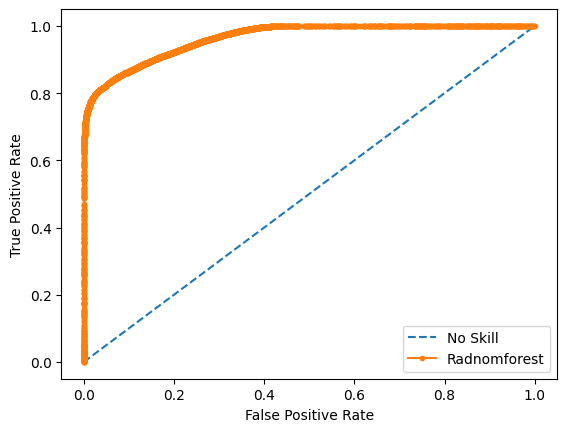

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, pred_df["PROB"])
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_df["PROB"])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Radnomforest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

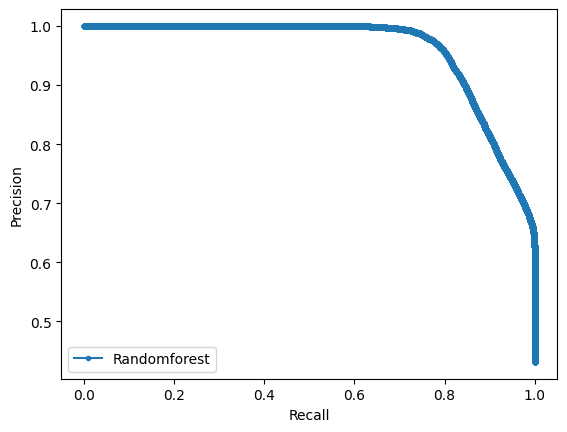

In [35]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred_df["PROB"])
plt.plot(lr_recall, lr_precision, marker='.', label='Randomforest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

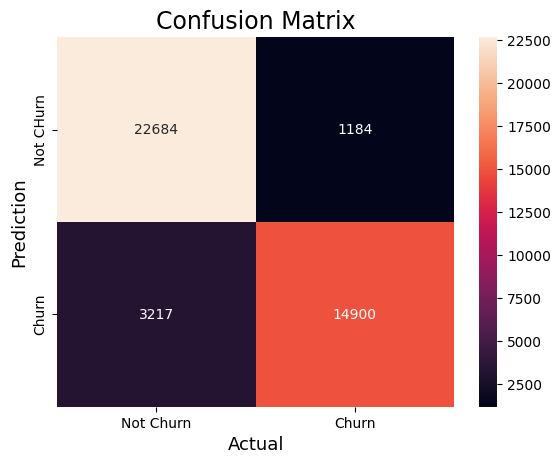

In [36]:
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not Churn','Churn'],
            yticklabels=['Not CHurn','Churn'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [37]:
scores_data = pd.DataFrame({"ns_probs":ns_probs,
                            "y_test":y_test,
                            "y_pred":pred_df["PREDICTION"],
                            "act_probs":pred_df["PROB"]})

In [38]:
scores_data

,ns_probs,y_test,y_pred,act_probs
265369,0,0,0,0.006075
141833,0,1,1,0.901443
234366,0,0,0,0.242532
95853,0,1,1,0.844350
88598,0,0,0,0.376696
...,...,...,...,...
227011,0,0,0,0.034653
13679,0,0,0,0.000140
94202,0,1,1,0.941833
252689,0,0,0,0.023080


In [40]:
scores_data.to_csv("scores.csv", index=False)

In [41]:
# Define or use the prediction function
def model_prediction_score_func(dataframe):
    # Ensure 'dataframe' has the correct features required by the model
    return pipeline.predict(dataframe)  # Use your trained pipeline/model here
 
# Assuming df is your input DataFrame with the necessary features
Original_df['Model_Output'] = model_prediction_score_func(Original_df)
 
# If you have a DataFrame with test data and you want to merge predictions
# Assuming X_test is the DataFrame for which predictions are made
#X_test_with_predictions = X_test.copy()
#X_test_with_predictions['Model_Output'] = model_prediction_score_func(X_test)
 
# Display the first few rows to verify
#print(X_test_with_predictions.head())

In [42]:
Original_df

,EMPLOYEE_ID,TENURE_MONTHS,BIRTH_YEAR,AGE,SENIORITY,SCHOOL_ENDDATE,MONTHS_AFTER_COLLEGE,PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH,PEOPLE_JOINED_AND_NEVER_LEFT,POPULATION,...,ORGANIZATION_OWNERSHIP,STATE,COUNTRY,GENDER,OVERTIME_HOURS,WORK_LIFE_BALANCE,BUSINESS_TRAVEL,ENVIRONMENT_SATISFACTION,USER_ID,Model_Output
0,95280676,43,1986,38,2,2009-01-31,30,0,0,0,...,Public,Illinois,United States,Male,16,Better,Travel Rarely,Very High,643748410,0
1,83315936,41,1988,36,2,2010-01-31,26,0,0,0,...,Public,Massachusetts,United States,Male,3,Good,Travel Rarely,Medium,597456704,0
2,46251572,23,1989,35,2,2015-01-01,13,0,0,0,...,Private,Illinois,United States,Male,9,Bad,Travel Rarely,Medium,509036022,0
3,21546520,10,1982,42,2,2003-01-01,139,0,53,53,...,Private,Florida,United States,Male,6,Better,Travel Rarely,Very High,546019147,1
4,16097940,24,1986,38,3,2013-01-31,11,0,0,0,...,Public,Florida,United States,Male,4,Good,Non-Travel,Low,447760669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299991,74881825,54,1979,45,2,2004-01-31,104,0,0,0,...,Public,Massachusetts,United States,Female,10,Bad,Travel Rarely,Low,218214855,0
299992,24493355,25,1997,27,1,2017-01-31,9,0,16,16,...,Non-Profit,California,United States,Female,6,Good,Travel Frequently,Low,810960945,0
299993,97247334,1,1994,30,1,2020-01-01,10,0,0,0,...,Private,California,United States,Female,3,Bad,Travel Rarely,Medium,18255040,1
299994,55999074,9,1990,34,4,2015-01-01,72,0,0,0,...,Public,California,United States,Male,8,Good,Travel Rarely,Very High,158992279,1


In [50]:
Original_df.to_csv("Attrition_Data_predictive.csv", index=False)

In [52]:
import pandas as pd
if 'Model_Output' in Original_df:
    Original_df['Model_Output_Values'] = Original_df['Model_Output'].astype(bool)
print(Original_df.head())


  EMPLOYEE_ID  TENURE_MONTHS BIRTH_YEAR AGE  SENIORITY SCHOOL_ENDDATE  \
0    95280676             43       1986  38          2     2009-01-31   
1    83315936             41       1988  36          2     2010-01-31   
2    46251572             23       1989  35          2     2015-01-01   
3    21546520             10       1982  42          2     2003-01-01   
4    16097940             24       1986  38          3     2013-01-31   

   MONTHS_AFTER_COLLEGE  PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH  \
0                    30                                            0   
1                    26                                            0   
2                    13                                            0   
3                   139                                            0   
4                    11                                            0   

   PEOPLE_JOINED_AND_NEVER_LEFT  POPULATION  ...          STATE  \
0                             0           0  ...       Illino

In [58]:
sf_df = my_session.createDataFrame(Original_df)
sf_df.write.mode("overwrite").save_as_table("Attrition_Data_predictive")
my_session.table("Attrition_Data_predictive").show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMPLOYEE_ID"  |"TENURE_MONTHS"  |"BIRTH_YEAR"  |"AGE"  |"SENIORITY"  |"SCHOOL_ENDDATE"  |"MONTHS_AFTER_COLLEGE"  |"PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH"  